# BUSINESS UNDERSTANDING

## Summary

- 주제: ***비식별화 된 시스템 기록(로그 및 수치 데이터)를 분석***하여 시스템 품질 변화로 사용자에게 불편을 야기하는 요인을 진단

- 배경: 다양한 장비/서비스에서 일어나는 시스템 데이터를 통해 사용자의 불편을 예지하기 위해 **'시스템 데이터'** 와 **'사용자 불편 발생 데이터'** 를 분석하여 ***불편을 느낀 사용자*** 와 ***불편 요인들*** 을 찾아주세요.

- 목적
    1. 데이터를 통해 ***사용자가 불편을 느끼는 원인 분석***
    2. ***사용자 관점*** 의 데이터 분석 능력이 뛰어난 인재 발굴

## Rule

1차 평가

1. Evaluation Metric: AUC(사용자로부터 불만 접수가 일어날 확률 예측)
2. Public score: 전체 테스트 데이터 중 33%
3. Private score: 전체 테스트 데이터 중 67%
4. 1차 평가의 최종 순위는 Private score

2차 평가

   1. 결과분석, 비즈니스 분석
   2. 사용자 불만 접수 원인 분석
   3. err_data의 err간 관계 해석
   4. quality_data 수치 해석
   5. err_data와 quality_data간의 관계 해석 필수 포함

기타

1. 외부데이터 금지
2. 사전학습모델 금지
3. 제공 된 학습 데이터 외 학습 불가
4. 테스트 데이터는 추론 과정에서만 사용 가능(train 불가)

## Data Describtion

학습 데이터 (user_id: 10,000 ~ 24,999, 15,000명)

- **train_e: 시스템에 발생한 에러 로그**
    1. user: 사용자
    2. time: 로그시간
    3. model_nm: 모델명
    4. fwver: 펌웨어버전
    5. errtype: 에러타입
    6. errcode: 에러코드
- **train_q: 시스템 퀄리티 로그**
    1. time: 로그시간
    2. user: 사용자
    3. fwver: 펌웨어버전
    4. quality_k: 퀄리티지표
- **train_p: 사용자 불만 및 불만이 접수된 시간**
    1. user: 사용자
    2. time: 불만 접수 시간

테스트 데이터(user_id: 30,000 ~ 44,998, 14999명)

- test_e: 상동
- test_q: 상동
- 테스트 데이터에는 test_p 테이블이 없음

## Discussion

주어진 기간 내에 err가 발생하지 않은 경우, err_set에 해당 user_id가 존재하지 않음. 즉 train_err, test_err 에 user_id가 없으면 err이 발생하지 않은 것임

# IMPORT & LOAD DATA

In [767]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')

import os, sys
import time
import datetime as dt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

In [2]:
TRAIN_P_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv'
TRAIN_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv'
TRAIN_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv'
TEST_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv'
TEST_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/sample_submission.csv'

In [591]:
%%time
train_p = ld.load_dtypes(TRAIN_P_PATH)
train_q = ld.load_dtypes(TRAIN_Q_PATH)
train_e = ld.load_dtypes(TRAIN_E_PATH)
test_q = ld.load_dtypes(TEST_Q_PATH)
test_e = ld.load_dtypes(TEST_E_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv
Wall time: 1min 17s


In [592]:
train_p.shape, train_q.shape, train_e.shape, test_q.shape, test_e.shape, submission.shape

((5429, 2),
 (828624, 16),
 (16554663, 6),
 (747972, 16),
 (16532648, 6),
 (14999, 2))

# DATA UNDERSTANDING

각 데이터 테이블의 이름이 너무 길기 때문에 아래와 같이 정의하겠습니다.

- train_problem_data -> train_p
- train_quality_data -> train_q
- train_err_data -> train_e
- test_quality_data -> test_q
- test_err_data -> test_e

## Data Table Opimization

### train_p optimization

In [593]:
train_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  5429 non-null   int16
 1   time     5429 non-null   int64
dtypes: int16(1), int64(1)
memory usage: 53.1 KB


user당 problem이 한개가 아닙니다.<br>
user_id 를 count 해서 target으로 넣어주겠습니다. null user를 0으로 넣어주어야겠습니다.<br>
그리고 time을 x_train으로 붙여서 정보를 얻어봐야겠습니다.

In [594]:
# 10001부터 24999까지의 index를 만들어줍니다.
user_id_idx = np.array(range(10000, 25000, 1))

# train_new_p라는 새로운 df를 만들고 index는 위에서 만든 user_id_idx 로 지정해줍니다.
train_new_p = pd.DataFrame(index = user_id_idx)

# target이라는 칼럼을 만들고, train_p를 user_id를 groupby해서 time을 count한 값을 넣어줍니다.
# index가 지정되어 있기 때문에, 해당 값에만 들어갑니다.
train_new_p['target'] = train_p.groupby('user_id')['time'].count()

# train_p에 존재하지 않는 user_id는 값을 받지 못해 Nan값이므로, 에러가 나지 않았다는 뜻의 0으로 채워줍니다.
train_new_p = train_new_p.fillna(0)

In [595]:
train_new_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 10000 to 24999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  15000 non-null  float64
dtypes: float64(1)
memory usage: 234.4 KB


In [596]:
# 기술통계를 살펴보면, max가 5로 되어있습니다.
# 일부러 {0,1} 의 이진분류로 값을 넣지 않고, 0~5의 int 값으로 넣었습니다.
# 회귀 문제로 가져갈 수도 있습니다.
train_new_p.describe().T

,count,mean,std,min,25%,50%,75%,max
target,15000.0,0.361933,0.544448,0.0,0.0,0.0,1.0,5.0


In [597]:
train_new_p.head()

,target
10000,0.0
10001,1.0
10002,0.0
10003,0.0
10004,1.0


In [598]:
train_p.sort_values('user_id').head()

,user_id,time
1116,10001,20201113190000
492,10004,20201104120000
3857,10005,20201113120000
3826,10006,20201110180000
414,10006,20201110170000


### train_q optimization

In [599]:
train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   time        828624 non-null  int64   
 1   user_id     828624 non-null  int16   
 2   fwver       788544 non-null  category
 3   quality_0   684192 non-null  float32 
 4   quality_1   828624 non-null  int16   
 5   quality_2   788511 non-null  float32 
 6   quality_3   828624 non-null  int8    
 7   quality_4   828624 non-null  int8    
 8   quality_5   828604 non-null  category
 9   quality_6   828624 non-null  int16   
 10  quality_7   828624 non-null  category
 11  quality_8   828624 non-null  category
 12  quality_9   828624 non-null  category
 13  quality_10  828624 non-null  category
 14  quality_11  828624 non-null  int8    
 15  quality_12  828624 non-null  int8    
dtypes: category(6), float32(2), int16(3), int64(1), int8(4)
memory usage: 28.9 MB


살펴본 결과 q 데이터는 전부 category라고 보는 게 맞는 것 같습니다. 형변환을 해주어야겠습니다.<br>
time도 데이트타임으로 짤라줍시다. 시간단위로 짜릅니다.

In [600]:
# 먼저 퀄리티 피쳐들을 리스트로 받아줍니다.
quality_features = ['quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']

# test셋에도 써야 하니 함수로 만들겠습니다.
def quality_as_category(df):
    # 함수 정의: df를 받아서 quality features를 category로 형변환해서 반환하는 함수
    
    for col in quality_features:
        try: # category가 아니면 에러가 나니, try-except로 합니다.
            if df[col].dtype == 'category':
                pass
        except: # error가 나면 category가 아니라는 뜻으로, 형변환을 해줍니다.
            df[col] = df[col].astype('category')
            
    return df

In [601]:
train_q = quality_as_category(train_q)

In [602]:
train_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   time        828624 non-null  int64   
 1   user_id     828624 non-null  int16   
 2   fwver       788544 non-null  category
 3   quality_0   684192 non-null  category
 4   quality_1   828624 non-null  category
 5   quality_2   788511 non-null  category
 6   quality_3   828624 non-null  category
 7   quality_4   828624 non-null  category
 8   quality_5   828604 non-null  category
 9   quality_6   828624 non-null  category
 10  quality_7   828624 non-null  category
 11  quality_8   828624 non-null  category
 12  quality_9   828624 non-null  category
 13  quality_10  828624 non-null  category
 14  quality_11  828624 non-null  category
 15  quality_12  828624 non-null  category
dtypes: category(14), int16(1), int64(1)
memory usage: 25.0 MB


### train_e opimization

In [603]:
train_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   user_id   int16   
 1   time      int64   
 2   model_nm  category
 3   fwver     category
 4   errtype   int8    
 5   errcode   category
dtypes: category(3), int16(1), int64(1), int8(1)
memory usage: 236.9 MB


errtype은 category 입니다. 형변환 해줍니다.<br>
time도 마찬가지로 데이트타임으로 짤라줍니다. 시간단위입니다.

In [604]:
# errtype 변수는 category로 형변환 해줍니다.
train_e['errtype'] = train_e.errtype.astype('category')
train_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   user_id   int16   
 1   time      int64   
 2   model_nm  category
 3   fwver     category
 4   errtype   category
 5   errcode   category
dtypes: category(4), int16(1), int64(1)
memory usage: 236.9 MB


### test_q optimization

In [605]:
test_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   time        747972 non-null  int64   
 1   user_id     747972 non-null  uint16  
 2   fwver       725208 non-null  category
 3   quality_0   641388 non-null  float32 
 4   quality_1   747961 non-null  category
 5   quality_2   726857 non-null  float32 
 6   quality_3   747972 non-null  int8    
 7   quality_4   747972 non-null  int8    
 8   quality_5   747928 non-null  category
 9   quality_6   747972 non-null  int16   
 10  quality_7   747972 non-null  category
 11  quality_8   747972 non-null  category
 12  quality_9   747972 non-null  category
 13  quality_10  747972 non-null  category
 14  quality_11  747972 non-null  int8    
 15  quality_12  747972 non-null  int8    
dtypes: category(7), float32(2), int16(1), int64(1), int8(4), uint16(1)
memory usage: 25.4 MB


마찬가지입니다.

In [606]:
test_q = quality_as_category(test_q)

In [607]:
test_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   time        747972 non-null  int64   
 1   user_id     747972 non-null  uint16  
 2   fwver       725208 non-null  category
 3   quality_0   641388 non-null  category
 4   quality_1   747961 non-null  category
 5   quality_2   726857 non-null  category
 6   quality_3   747972 non-null  category
 7   quality_4   747972 non-null  category
 8   quality_5   747928 non-null  category
 9   quality_6   747972 non-null  category
 10  quality_7   747972 non-null  category
 11  quality_8   747972 non-null  category
 12  quality_9   747972 non-null  category
 13  quality_10  747972 non-null  category
 14  quality_11  747972 non-null  category
 15  quality_12  747972 non-null  category
dtypes: category(14), int64(1), uint16(1)
memory usage: 22.6 MB


### test_e optimization

In [608]:
test_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16532648 entries, 0 to 16532647
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   user_id   uint16  
 1   time      int64   
 2   model_nm  category
 3   fwver     category
 4   errtype   int8    
 5   errcode   category
dtypes: category(3), int64(1), int8(1), uint16(1)
memory usage: 236.6 MB


In [609]:
test_e['errtype'] = test_e.errtype.astype('category')
test_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16532648 entries, 0 to 16532647
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   user_id   uint16  
 1   time      int64   
 2   model_nm  category
 3   fwver     category
 4   errtype   category
 5   errcode   category
dtypes: category(4), int64(1), uint16(1)
memory usage: 236.6 MB


In [610]:
submission

,user_id,problem
0,30000,0
1,30001,0
2,30002,0
3,30003,0
4,30004,0
...,...,...
14994,44994,0
14995,44995,0
14996,44996,0
14997,44997,0


## Unique Values Check

In [160]:
# category feature가 많으니 unique value를 체크해야 합니다.
# 그와 함께 value_counts()도 체크해서 imbalance를 체크해야 합니다.

def show_unique(train):
    # 함수정의: df를 받아서 각 칼럼에 대해 category는 unique()와 value_counts()[:10] 를 반환하는 함수
    
    columns = train.columns
    for col in columns:
        try: # 마찬가지로 try except를 씁니다.
            if (train[col].dtype == 'category'):
                print("----------------------------------------")
                print("{}'s Unique Values Count are: ".format(col), train[col].nunique())
                print("{}'s Unique Values are: ".format(col), train[col].unique())
                print("{}'s Top 10 Value Counts are: ".format(col))
                print(train[col].value_counts()[:10])
            else:
                pass
        except:
            pass

In [161]:
show_unique(train_q)

----------------------------------------
fwver's Unique Values Count are:  27
fwver's Unique Values are:  [05.15.2138, 04.22.1750, 04.16.3553, 04.33.1261, 04.22.1778, ..., 04.16.3439, 04.73.2571, 05.15.2114, 04.16.3345, 04.22.1442]
Length: 28
Categories (27, object): [05.15.2138, 04.22.1750, 04.16.3553, 04.33.1261, ..., 04.73.2571, 05.15.2114, 04.16.3345, 04.22.1442]
fwver's Top 10 Value Counts are: 
05.15.2138    163236
04.22.1750    142032
04.33.1261    131340
04.16.3553    111996
03.11.1167    104148
04.33.1185     66024
04.22.1778     56472
04.22.1684      3420
09.17.1431      3384
04.16.3571      2232
Name: fwver, dtype: int64
----------------------------------------
quality_0's Unique Values Count are:  753
quality_0's Unique Values are:  [0.0, 2.0, -1.0, NaN, 1.0, ..., 122.0, 228.0, 305.0, 188.0, 2351.0]
Length: 754
Categories (753, float64): [0.0, 2.0, -1.0, 1.0, ..., 228.0, 305.0, 188.0, 2351.0]
quality_0's Top 10 Value Counts are: 
 0.0    542790
-1.0    130828
 1.0      2097

In [162]:
show_unique(test_q)

----------------------------------------
fwver's Unique Values Count are:  22
fwver's Unique Values are:  [04.33.1261, 05.15.2138, 04.22.1750, 04.22.1778, 04.16.3553, ..., 03.11.1149, 05.15.2120, 04.33.1125, 04.16.3439, 05.15.2114]
Length: 23
Categories (22, object): [04.33.1261, 05.15.2138, 04.22.1750, 04.22.1778, ..., 05.15.2120, 04.33.1125, 04.16.3439, 05.15.2114]
fwver's Top 10 Value Counts are: 
05.15.2138    142704
04.22.1750    141912
04.33.1261    121584
04.16.3553    109056
03.11.1167     84240
04.22.1778     59736
04.33.1185     57828
04.16.3571      2172
04.22.1684      1464
03.11.1149      1188
Name: fwver, dtype: int64
----------------------------------------
quality_0's Unique Values Count are:  540
quality_0's Unique Values are:  [0.0, -1.0, NaN, 2.0, 8.0, ..., 10249.0, 10627.0, 10452.0, 2011.0, 239.0]
Length: 541
Categories (540, float64): [0.0, -1.0, 2.0, 8.0, ..., 10627.0, 10452.0, 2011.0, 239.0]
quality_0's Top 10 Value Counts are: 
 0.0    505710
-1.0    127001
 1.0

In [163]:
show_unique(train_e)

----------------------------------------
model_nm's Unique Values Count are:  9
model_nm's Unique Values are:  [model_3, model_2, model_0, model_1, model_7, model_4, model_5, model_8, model_6]
Categories (9, object): [model_3, model_2, model_0, model_1, ..., model_4, model_5, model_8, model_6]
model_nm's Top 10 Value Counts are: 
model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64
----------------------------------------
fwver's Unique Values Count are:  37
fwver's Unique Values are:  [05.15.2138, 04.33.1185, 04.33.1261, 04.22.1750, 04.22.1778, ..., 04.22.1656, 04.16.2641, 05.15.2114, 04.16.3345, 05.15.2092]
Length: 37
Categories (37, object): [05.15.2138, 04.33.1185, 04.33.1261, 04.22.1750, ..., 04.16.2641, 05.15.2114, 04.16.3345, 05.15.2092]
fwver's Top 10 Value Counts are: 
04.16.3553    5237816
04.22.1750    2874213
04.33.1261    250487

In [164]:
show_unique(test_e)

----------------------------------------
model_nm's Unique Values Count are:  9
model_nm's Unique Values are:  [model_1, model_2, model_3, model_0, model_4, model_5, model_6, model_7, model_8]
Categories (9, object): [model_1, model_2, model_3, model_0, ..., model_5, model_6, model_7, model_8]
model_nm's Top 10 Value Counts are: 
model_1    5473847
model_0    4350571
model_2    3601258
model_3    1801452
model_4    1215796
model_5      35462
model_7      28694
model_8      24994
model_6        574
Name: model_nm, dtype: int64
----------------------------------------
fwver's Unique Values Count are:  40
fwver's Unique Values are:  [04.16.3553, 04.16.3571, 04.33.1261, 05.15.2138, 04.22.1750, ..., 10.22.1770, 10.22.1780, 04.16.3569, 04.22.1772, 04.22.1170]
Length: 40
Categories (40, object): [04.16.3553, 04.16.3571, 04.33.1261, 05.15.2138, ..., 10.22.1780, 04.16.3569, 04.22.1772, 04.22.1170]
fwver's Top 10 Value Counts are: 
04.16.3553    5326124
04.22.1750    2969638
04.33.1261    260719

## Null Data Check & Missing Value Check

In [209]:
def check_train_test_column_values(train, test, column):
    # 함수 정의: 두 데이터 테이블과 특정 컬럼을 집어 넣으면 value를 비교하여 출력하는 함수
    
    # Train/Test set의 입력 칼럼의 value를 set으로 받아줍니다.
    train_colset = set(train[column])
    test_colset  = set(test[column])

    # Train/Test-set 고유한 value의 개수를 구함.
    print(f"Train-set에 있는 고유한 value 개수 : {len(train_colset)}")
    print(f"Test-set에 있는 고유한 value 개수 : {len(test_colset)}")

    # Train/Test-set 모두에 포함되어있는 value를 구함.
    print('='* 80)
    common_colset = train_colset.intersection(test_colset)
    print(f"Train/Test-set에 공통으로 포함되어 있는 value 개수 : {len(common_colset)}")
    if len(common_colset) > 100: # value가 너무 많으면 어차피 보기 힘드므로 출력을 pass 합니다
        pass
    else:
        try: # int나 float은 sorted가 먹지 않기 때문에 try except로 넣어줍니다.
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {sorted(common_colset)}")
        except:
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {(common_colset)}")

    # Train-set에만 있는 value를 구함.
    print('='* 80)
    train_only_colset = train_colset.difference(test_colset)
    print(f"Train-set에만 있는 value는 총 {len(train_only_colset)} 개 입니다.")
    if len(train_only_colset) > 100:.
        pass
    else:
        try:
            print(f"Train-set에만 있는 value는 : {sorted(train_only_colset)}")
        except:
            print(f"Train-set에만 있는 value는 : {(train_only_colset)}")

    # Test-set에만 있는 value를 구함.
    print('='* 80)
    test_only_colset = test_colset.difference(train_colset)
    print(f"Test-set에만 있는 value는 총 {len(test_only_colset)} 개 입니다.")
    if len(test_only_colset) > 100:
        pass
    else:
        try:
            print(f"Test-set에만 있는 value는 : {sorted(test_only_colset)}")
        except:
            print(f"Test-set에만 있는 value는 : {(test_only_colset)}")

In [210]:
check_train_test_column_values(train_e, test_e, 'errtype')

Train-set에 있는 고유한 value 개수 : 41
Test-set에 있는 고유한 value 개수 : 41
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 41
Train/Test-set에 공통으로 포함되어 있는 value : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []


In [211]:
check_train_test_column_values(train_e, test_e, 'fwver')

Train-set에 있는 고유한 value 개수 : 37
Test-set에 있는 고유한 value 개수 : 40
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 31
Train/Test-set에 공통으로 포함되어 있는 value : ['03.11.1141', '03.11.1149', '03.11.1167', '04.16.3439', '04.16.3553', '04.16.3569', '04.16.3571', '04.22.1656', '04.22.1666', '04.22.1684', '04.22.1750', '04.22.1778', '04.33.1125', '04.33.1149', '04.33.1171', '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2571', '04.82.1684', '04.82.1730', '04.82.1778', '05.15.2092', '05.15.2114', '05.15.2120', '05.15.2138', '05.15.3104', '05.66.3237', '05.66.3571', '10', '8.5.3']
Train-set에만 있는 value는 총 6 개 입니다.
Train-set에만 있는 value는 : ['04.16.2641', '04.16.3345', '04.22.1442', '04.33.1095', '05.15.2090', '05.15.2122']
Test-set에만 있는 value는 총 9 개 입니다.
Test-set에만 있는 value는 : ['04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1772', '04.73.2569', '04.73.2577', '10.22.1770', '10.22.1780']


In [212]:
check_train_test_column_values(train_e, test_e, 'model_nm')

Train-set에 있는 고유한 value 개수 : 9
Test-set에 있는 고유한 value 개수 : 9
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 9
Train/Test-set에 공통으로 포함되어 있는 value : ['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8']
Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []


In [213]:
check_train_test_column_values(train_e, test_e, 'errcode')

Train-set에 있는 고유한 value 개수 : 2806
Test-set에 있는 고유한 value 개수 : 2956
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 1408
Train-set에만 있는 value는 총 1398 개 입니다.
Test-set에만 있는 value는 총 1548 개 입니다.


In [214]:
check_train_test_column_values(train_q, test_q, 'fwver')

Train-set에 있는 고유한 value 개수 : 28
Test-set에 있는 고유한 value 개수 : 23
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 23
Train/Test-set에 공통으로 포함되어 있는 value : {nan, '04.82.1778', '04.82.1684', '04.22.1778', '05.66.3237', '04.33.1261', '04.33.1149', '05.15.2120', '04.22.1750', '05.15.2138', '05.66.3571', '09.17.1431', '04.33.1125', '04.22.1684', '03.11.1167', '04.16.3439', '04.33.1185', '04.73.2571', '04.16.3571', '03.11.1149', '04.16.3553', '04.73.2237', '05.15.2114'}
Train-set에만 있는 value는 총 5 개 입니다.
Train-set에만 있는 value는 : ['04.16.3345', '04.22.1442', '04.22.1656', '04.22.1666', '05.15.2122']
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []


train_q와 train_e, test_q와 test_e 에 있는 fwver이 각각 다른 것 같아서 이것도 체크를 해봐야겠습니다.

In [530]:
check_train_test_column_values(train_q, train_e, 'fwver')

Train-set에 있는 고유한 value 개수 : 28
Test-set에 있는 고유한 value 개수 : 37
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 26
Train/Test-set에 공통으로 포함되어 있는 value : ['03.11.1149', '03.11.1167', '04.16.3345', '04.16.3439', '04.16.3553', '04.16.3571', '04.22.1442', '04.22.1656', '04.22.1666', '04.22.1684', '04.22.1750', '04.22.1778', '04.33.1125', '04.33.1149', '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2571', '04.82.1684', '04.82.1778', '05.15.2114', '05.15.2120', '05.15.2122', '05.15.2138', '05.66.3237', '05.66.3571']
Train-set에만 있는 value는 총 2 개 입니다.
Train-set에만 있는 value는 : {nan, '09.17.1431'}
Test-set에만 있는 value는 총 11 개 입니다.
Test-set에만 있는 value는 : ['03.11.1141', '04.16.2641', '04.16.3569', '04.33.1095', '04.33.1171', '04.82.1730', '05.15.2090', '05.15.2092', '05.15.3104', '10', '8.5.3']


In [531]:
check_train_test_column_values(test_q, test_e, 'fwver')

Train-set에 있는 고유한 value 개수 : 23
Test-set에 있는 고유한 value 개수 : 40
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 21
Train/Test-set에 공통으로 포함되어 있는 value : ['03.11.1149', '03.11.1167', '04.16.3439', '04.16.3553', '04.16.3571', '04.22.1684', '04.22.1750', '04.22.1778', '04.33.1125', '04.33.1149', '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2571', '04.82.1684', '04.82.1778', '05.15.2114', '05.15.2120', '05.15.2138', '05.66.3237', '05.66.3571']
Train-set에만 있는 value는 총 2 개 입니다.
Train-set에만 있는 value는 : {nan, '09.17.1431'}
Test-set에만 있는 value는 총 19 개 입니다.
Test-set에만 있는 value는 : ['03.11.1141', '04.16.3569', '04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1656', '04.22.1666', '04.22.1772', '04.33.1171', '04.73.2569', '04.73.2577', '04.82.1730', '05.15.2092', '05.15.3104', '10', '10.22.1770', '10.22.1780', '8.5.3']


'09.17.1431', nan 두 개만 e데이터에 없습니다. q데이터는 많이 부족합니다.

**errtype, model_nm** 은 train_test 가 일치합니다. 다만 **fwver** 은 일치하지 않습니다. **errcode** 는 절반 정도가 일치하지 않습니다. 이 데이터들을 정리해줘야 합니다.

quality는 연산이 많이 걸려서 체크조차 못합니다. 다만 위에서 unique_value_counts()를 봤을 때 train_test에 일치하지 않는 column이 많습니다. 문제가 많습니다...!

In [216]:
train_q.quality_0.unique()

[0.0, 2.0, -1.0, NaN, 1.0, ..., 122.0, 228.0, 305.0, 188.0, 2351.0]
Length: 754
Categories (753, float64): [0.0, 2.0, -1.0, 1.0, ..., 228.0, 305.0, 188.0, 2351.0]

In [217]:
test_q.quality_0.unique()

[0.0, -1.0, NaN, 2.0, 8.0, ..., 10249.0, 10627.0, 10452.0, 2011.0, 239.0]
Length: 541
Categories (540, float64): [0.0, -1.0, 2.0, 8.0, ..., 10627.0, 10452.0, 2011.0, 239.0]

단순히 0번 퀄리티를 보기만 하더라도 value값이 많이 다르며, 유니크 개수도 다릅니다. 퀄리티를 컬럼으로 변환하기는 힘들 것 같습니다.

In [236]:
pd.to_datetime(train_q.time, format='%Y-%m-%d %H:%M:%S')

0        1970-01-01 05:36:41.129090
1        1970-01-01 05:36:41.129090
2        1970-01-01 05:36:41.129090
3        1970-01-01 05:36:41.129090
4        1970-01-01 05:36:41.129090
                    ...            
828619   1970-01-01 05:36:41.124033
828620   1970-01-01 05:36:41.124033
828621   1970-01-01 05:36:41.124033
828622   1970-01-01 05:36:41.124033
828623   1970-01-01 05:36:41.124033
Name: time, Length: 828624, dtype: datetime64[ns]

In [241]:
train_q.groupby(['user_id', 'fwver']).count().reset_index()

,user_id,fwver,time,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,03.11.1149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,03.11.1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,04.16.3553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,04.16.3571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,04.22.1750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223582,24997,04.16.3439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223583,24997,04.73.2571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223584,24997,05.15.2114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223585,24997,04.16.3345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


특이합니다. 많이 특이합니다. 일단 y_train 값은 user의 problem이 접수된 시간을 보여줍니다. 그렇다보니 user당 problem이 한 개가 아닙니다. 여러개가 있을 수 있습니다.

그러나 submission은 yes or no로 제출해야 합니다. 심지어 그것을 확률로 제출해야 합니다. 즉 모든 user에 대해서 problem이 1개라도 발생할 확률을 구해야 합니다.

이건 어찌보면 classification일 수 있습니다. 그러나 regression도 될 수 있습니다. 0 ~ n 까지의 target data가 있다고 생각하면 되니까요.

데이터도 매우 특이합니다. user-time 으로 테이블이 구성되어 있고, 퀄리티는 category인 것 같은데, 시간별로 계속 변합니다.

에러 데이터도 마찬가지입니다. 다양한 err code가 있습니다. model_nm, fwver 은 뭔지도 모르겠습니다.

Null data와 missing value 도 매우 많습니다.

# Vanila Modeling

활용할 수 있는 데이터가 많지만, 모든 데이터를 활용하려면 많은 고민이 필요할 것 같습니다.<br>

가장 먼저 아주 기본적인 다변량회귀 문제로 풀겠습니다. 유저별로 변수를 뭉쳐야 합니다.

### train_e

In [402]:
%%time
temp_1 = train_e.groupby(['user_id', 'model_nm'])['errcode'].count().unstack()
temp_1.columns = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4',
                  'model_5', 'model_7', 'model_8', 'model_6']

Wall time: 1.85 s


In [403]:
%%time
temp_2 = train_e.groupby(['user_id', 'fwver'])['errcode'].count().unstack()
temp_2.columns = ['03.11.1149', '03.11.1167', '04.16.3553', '04.16.3571',
                  '04.22.1684', '04.22.1750', '04.22.1778', '04.33.1149',
                  '04.33.1171', '04.33.1185', '04.33.1261', '04.82.1684',
                  '04.82.1778', '05.15.2138', '05.66.3237', '05.66.3571',
                  '04.73.2237', '10', '04.82.1730', '04.73.2571', '8.5.3',
                  '04.22.1666', '03.11.1141', '05.15.2120', '04.33.1125',
                  '04.16.3439', '04.22.1442', '04.33.1095', '04.16.3569',
                  '05.15.2090', '05.15.3104', '05.15.2122', '04.22.1656',
                  '04.16.2641', '05.15.2114', '04.16.3345', '05.15.2092']

Wall time: 4.35 s


In [404]:
%%time
temp_3 = train_e.groupby(['user_id', 'errtype'])['errcode'].count().unstack()
temp_3.columns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 101, 11, 12, 13, 14, 15, # 10을 임시로 101로 넣습니다.
                  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31,
                  32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

Wall time: 4.73 s


In [405]:
train_user = pd.concat([temp_1, temp_2, temp_3], axis=1)
train_user.shape

(15000, 87)

In [406]:
#Test-set에만 있는 value는 : ['04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1772', '04.73.2569', '04.73.2577', '10.22.1770', '10.22.1780']

In [407]:
columns = ['04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1772',
           '04.73.2569', '04.73.2577', '10.22.1770', '10.22.1780']

for col in columns:
    train_user[col] = np.zeros(train_user.shape[0],)
    
train_user.shape

(15000, 96)

### train_q

In [408]:
#temp_x = train_q.drop('time', axis=1).groupby(['user_id', 'fwver']).count().unstack()

In [409]:
#ind = pd.Index([e[0] + e[1] for e in temp_x.columns.tolist()])

In [410]:
#temp_x.columns = ind

### train_q + train_e

In [411]:
#train_user = pd.concat([train_user, temp_x], axis=1)

In [412]:
#train_user = train_user.fillna(0)

In [413]:
#train_user

### test_e

In [414]:
%%time
temp_1 = test_e.groupby(['user_id', 'model_nm'])['errcode'].count().unstack()
temp_1.columns = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4',
                  'model_5', 'model_6', 'model_7', 'model_8']

Wall time: 1.94 s


In [415]:
%%time
temp_2 = test_e.groupby(['user_id', 'fwver'])['errcode'].count().unstack()
temp_2.columns = ['03.11.1167', '04.16.3553', '04.16.3571', '04.22.1684',
                  '04.22.1750', '04.22.1778', '04.33.1149', '04.33.1185',
                  '04.33.1261', '05.15.2120', '05.15.2138', '04.82.1684',
                  '04.82.1778', '05.66.3237', '10', '04.73.2237', '04.73.2569',
                  '04.73.2571', '04.73.2577', '04.82.1730', '04.22.1478',
                  '8.5.3', '04.22.1656', '04.22.1666', '03.11.1149',
                  '04.33.1171', '05.66.3571', '04.16.3439', '05.15.2092',
                  '03.11.1141', '04.22.1608', '04.33.1125', '05.15.3104',
                  '04.22.1448', '05.15.2114', '10.22.1770', '10.22.1780',
                  '04.16.3569', '04.22.1772', '04.22.1170']

Wall time: 4.53 s


In [416]:
%%time
temp_3 = test_e.groupby(['user_id', 'errtype'])['errcode'].count().unstack()
temp_3.columns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 101, 11, 12, 13, 14, 15, # 10을 임시로 101로 넣습니다. 컬럼이 겹칩니다.
                  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31,
                  32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

Wall time: 4.6 s


In [417]:
test_user = pd.concat([temp_1, temp_2, temp_3], axis=1)
test_user.shape
# user 하나 사라짐 43262입니다.

(14998, 90)

In [418]:
# 하나 사라진 유저를 채워주는 코드입니다.
test_user = test_user.reindex(pd.RangeIndex(test_user.index.max() + 1)).ffill(0)[30000:]

In [419]:
test_user

,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,03.11.1167,04.16.3553,04.16.3571,04.22.1684,04.22.1750,04.22.1778,04.33.1149,04.33.1185,04.33.1261,05.15.2120,05.15.2138,04.82.1684,04.82.1778,05.66.3237,10,04.73.2237,04.73.2569,04.73.2571,04.73.2577,04.82.1730,04.22.1478,8.5.3,04.22.1656,04.22.1666,03.11.1149,04.33.1171,05.66.3571,04.16.3439,05.15.2092,03.11.1141,04.22.1608,04.33.1125,05.15.3104,04.22.1448,05.15.2114,10.22.1770,10.22.1780,04.16.3569,04.22.1772,04.22.1170,1,2,3,4,5,6,7,8,9,101,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
30000,0.0,2687.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2320.0,367.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0
30001,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30002,941.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,733.0,208.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0
30003,371.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0
30004,0.0,623.0,258.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,623.0,0.0,0.0,0.0,0.0,3.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0.0,1115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,123.0,93.0,12.0,0.0,0.0,0.0,0.0,197.0,204.0,0.0,0.0,31.0,0.0,0.0,0.0,179.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,87.0,0.0
44995,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,474.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,15.0,1.0,4.0,149.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,183.0,0.0,14.0,1.0,0.0,1.0,1.0,0.0,0.0,12.0,17.0,0.0
44996,2233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0,631.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,12.0,13.0,1.0,3.0,129.0,90.0,2.0,0.0,0.0,0.0,0.0,138.0,165.0,0.0,0.0,48.0,0.0,0

In [420]:
#Train-set에만 있는 value는 : ['04.16.2641', '04.16.3345', '04.22.1442', '04.33.1095', '05.15.2090', '05.15.2122']

In [421]:
columns = ['04.16.2641', '04.16.3345', '04.22.1442', '04.33.1095', '05.15.2090', '05.15.2122']

for col in columns:
    test_user[col] = np.zeros(test_user.shape[0],)
    
test_user.shape

(14999, 96)

### test_q

In [422]:
#temp_x = test_q.drop('time', axis=1).groupby(['user_id', 'fwver']).count().unstack()

In [423]:
#ind = pd.Index([e[0] + e[1] for e in temp_x.columns.tolist()])

In [424]:
#temp_x.columns = ind

### train_q + train_e

In [425]:
#test_user = pd.concat([test_user, temp_x], axis=1)

In [426]:
#test_user = test_user.fillna(0)

In [427]:
#test_user

### Matching columns

In [428]:
train_user.shape, test_user.shape, train_new_p.shape

((15000, 96), (14999, 96), (15000, 1))

In [429]:
train_user.columns.difference(test_user.columns)

Index([], dtype='object')

### fit and predict

In [443]:
new_target = []
for i in train_new_p.target:
    if i == 0:
        new_target.append(0)
    else:
        new_target.append(1)
        
train_new_p.target = new_target

In [445]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(train_user, train_new_p)
lgbm_pred = lgbm.predict(test_user)

In [446]:
submission.problem = (lgbm_pred > 0.5).astype(int)

In [448]:
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210110_2_test_binary.csv', index=False)

역시 기본적으로 다중분류보다는 이진분류가 성능이 높습니다.

# DATA PREPROCESSING

In [498]:
%%time
train_p = ld.load_dtypes(TRAIN_P_PATH)
train_q = ld.load_dtypes(TRAIN_Q_PATH)
train_e = ld.load_dtypes(TRAIN_E_PATH)
test_q = ld.load_dtypes(TEST_Q_PATH)
test_e = ld.load_dtypes(TEST_E_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv
Wall time: 1min 18s


## Feature Engineering

### column: time

time 변수가 매우 중요할 것 같은데, 활용할 방법이 없습니다. user축으로 가게 되면 time을 버려야 하고, time축으로 가면 user관점을 넣기가 매우 어렵습니다. user축 기준으로 time을 쓸 수 있을지 살펴보아야겠습니다.

time축을 맞추기 위해서는 가장 정보가 적은 테이블을 기준으로 해야하는데, hour가 가장 상위 기준입니다. 다른 테이블에는 min과 sec도 있지만, 사용할 수가 없습니다. 결국 hour를 최소한의 기준으로 해서 datetime을 만들어줘야겠습니다.

In [507]:
def make_datetime(df, column_name):
    # df 와 column_name을 받아서 datetime 컬럼을 반환해주는 함수
    
    df['year'] = df[column_name].apply(lambda x: str(x)[:4])
    df['month'] = df[column_name].apply(lambda x: str(x)[4:6])
    df['day'] = df[column_name].apply(lambda x: str(x)[6:8])
    df['hour'] = df[column_name].apply(lambda x: str(x)[8:10])
    df['minute'] = '00' # minute을 넣어주지 않으면 datetime이 완성이 안되니, 00으로 넣어줍니다.
    
    df[column_name] = pd.to_datetime(df.year + df.month + df.day + df.hour + df.minute)
    
    return df

In [508]:
train_q = make_datetime(train_q, 'time')
train_e = make_datetime(train_e, 'time')
test_q = make_datetime(test_q, 'time')
test_e = make_datetime(test_e, 'time')
train_p = make_datetime(train_p, 'time')

train_p와 train_e 의 시간축에서 관계를 살펴보고자 합니다. 보통 err이 뜬 이후 얼마가 지났을 때, 불만접수가 되는지를 알 수 있다면 좋은 정보가 될 수도 있습니다.

In [525]:
min(train_p.time), max(train_p.time)

(Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-30 23:00:00'))

In [524]:
min(train_q.time), max(train_q.time)

(Timestamp('2020-10-31 23:00:00'), Timestamp('2020-11-30 23:00:00'))

In [528]:
min(test_q.time), max(test_q.time)

(Timestamp('2020-10-31 23:00:00'), Timestamp('2020-11-30 23:00:00'))

In [526]:
min(train_e.time), max(train_e.time)

(Timestamp('2020-10-31 23:00:00'), Timestamp('2020-12-02 18:00:00'))

In [529]:
min(test_e.time), max(test_e.time)

(Timestamp('2020-10-31 23:00:00'), Timestamp('2020-12-14 12:00:00'))

일단 데이터의 기간을 살펴보면, 기본적으로 2020년 11월의 데이터를 보여주고 있습니다.<br>
다만 train_p(target)은 11월 1일부터 11월 30일 자정까지 딱 한달.<br>
train_q는 한시간 전인, 10월 31일 23시부터, test_q도 마찬가지.<br>
에러를 보여주는 train_e는 12월 2일 18시까지, test_e는 12월 14일 12시까지.<br>

In [509]:
train_e.sort_values('time')

,user_id,time,model_nm,fwver,errtype,errcode,year,month,day,hour,minute
13585684,22385,2020-10-31 23:00:00,model_2,04.33.1185,26,1,2020,10,31,23,00
13424899,22249,2020-10-31 23:00:00,model_0,04.22.1750,26,1,2020,10,31,23,00
9204586,18418,2020-10-31 23:00:00,model_0,04.22.1750,26,1,2020,10,31,23,00
6409135,15801,2020-10-31 23:00:00,model_0,04.22.1750,16,1,2020,10,31,23,00
12134438,20974,2020-10-31 23:00:00,model_0,04.22.1750,26,1,2020,10,31,23,00
...,...,...,...,...,...,...,...,...,...,...,...
8515387,17726,2020-12-01 21:00:00,model_1,04.16.3553,10,1,2020,12,01,21,00
10014476,19201,2020-12-01 21:00:00,model_3,05.15.2138,10,1,2020,12,01,21,00
5119339,14779,2020-12-02 02:00:00,model_1,04.16.3553,13,1,2020,12,02,02,00
4378222,14187,2020-12-02 03:00:00,model_3,05.15.2138,5,H-51042,2020,12,02,03,00


In [543]:
train_q.sort_values('time')

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,year,month,day,hour,minute
817676,2020-10-31 23:00:00,24867,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,27,0,0,2020,10,31,23,00
341336,2020-10-31 23:00:00,16119,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,12,0,0,2020,10,31,23,00
341335,2020-10-31 23:00:00,16119,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,12,0,0,2020,10,31,23,00
341334,2020-10-31 23:00:00,16119,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,12,0,0,2020,10,31,23,00
341333,2020-10-31 23:00:00,16119,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,12,0,0,2020,10,31,23,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703458,2020-11-30 23:00:00,22851,04.33.1261,0.0,0,0.0,0,0,1,0,0,0,0,9,0,0,2020,11,30,23,00
703459,2020-11-30 23:00:00,22851,04.33.1261,0.0,0,0.0,0,0,5,0,0,0,0,9,0,0,2020,11,30,23,00
703460,2020-11-30 23:00:00,22851,04.33.1261,0.0,0,0.0,0,0,0,0,0,0,0,9,0,0,2020,11,30,23,00
791536,2020-11-30 23:00:00,24408,04.33.1261,0.0,0,0.0,0,0,1,0,0,0,0,16,0,0,2020,11,30,23,00


### column: quality

unique value와 value_count를 보고 찾아낸 것입니다.

- quality 변수가 0부터 12까지 있습니다. 총 13개입니다.
- 대부분의 q변수들은 0이 대다수입니다.
- q_0 ~ q_2, q_5, q_6, q_11은 0> -1> 1 순으로 값을 가집니다.
- q_3, q_4는 전부 값이 0입니다. drop을 해야 합니다.
- q_7 ~ q_9, q_12는 -1이 없습니다.
- q_10은 3>2>0>1 순이며, 다른 변수보다 imbalance 정도가 훨씬 적습니다.

결국 3번과 4번은 drop, 나머지는 int 로 형변환을 하겠습니다.

- 가설을 세워보면, 3번과 4번이 0으로 되어 있는 것이면, 0이 기준점이 아닐까 합니다.
- 여기서 0을 넘어가서 큰 단위로 넘어갈수록 문제가 생기지 않을까 합니다.
- 문제는 -1 입니다. 얘는 도대체 무엇일까요.

두 가지 방식으로 활용해볼 수 있을 것 같습니다.

- -1, 0, 1 세 가지로 바꿔서 쓰는 방법
- int로 바꿔서 모든 퀄리티를 sum 해주는 방법

In [621]:
# test셋에도 써야 하니 함수로 만들겠습니다.
def quality_as_float(df, columns):
    # 함수 정의: df를 받아서 quality features를 category로 형변환해서 반환하는 함수
    
    for col in columns:
        try:
            df[col] = df[col].astype('object')
            # nan값이 있으면 float으로 갈 수 없으니 '0' 으로 채워줍니다.
            df[col] = df[col].fillna('0')
            df[col] = df[col].apply(lambda x: x.replace(',' , ''))
            df[col] = df[col].astype(np.float64)
        except:
            pass
        
    return df

In [630]:
train_q = quality_as_float(train_q, quality_features)
test_q = quality_as_float(test_q, quality_features)

In [625]:
plot_qaulity = ['quality_0', 'quality_1', 'quality_2','quality_5', 'quality_6', 'quality_7',
                    'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']

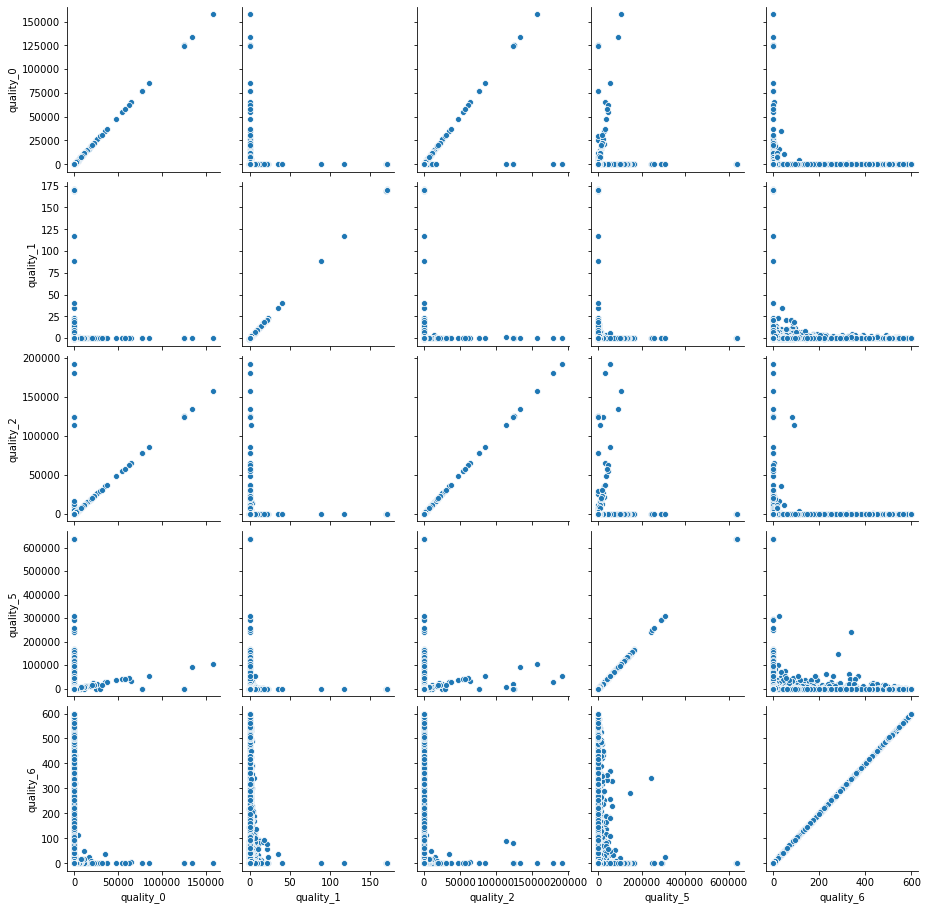

In [628]:
g = sns.PairGrid(tt[plot_qaulity[:5]])
g.map(sns.scatterplot)

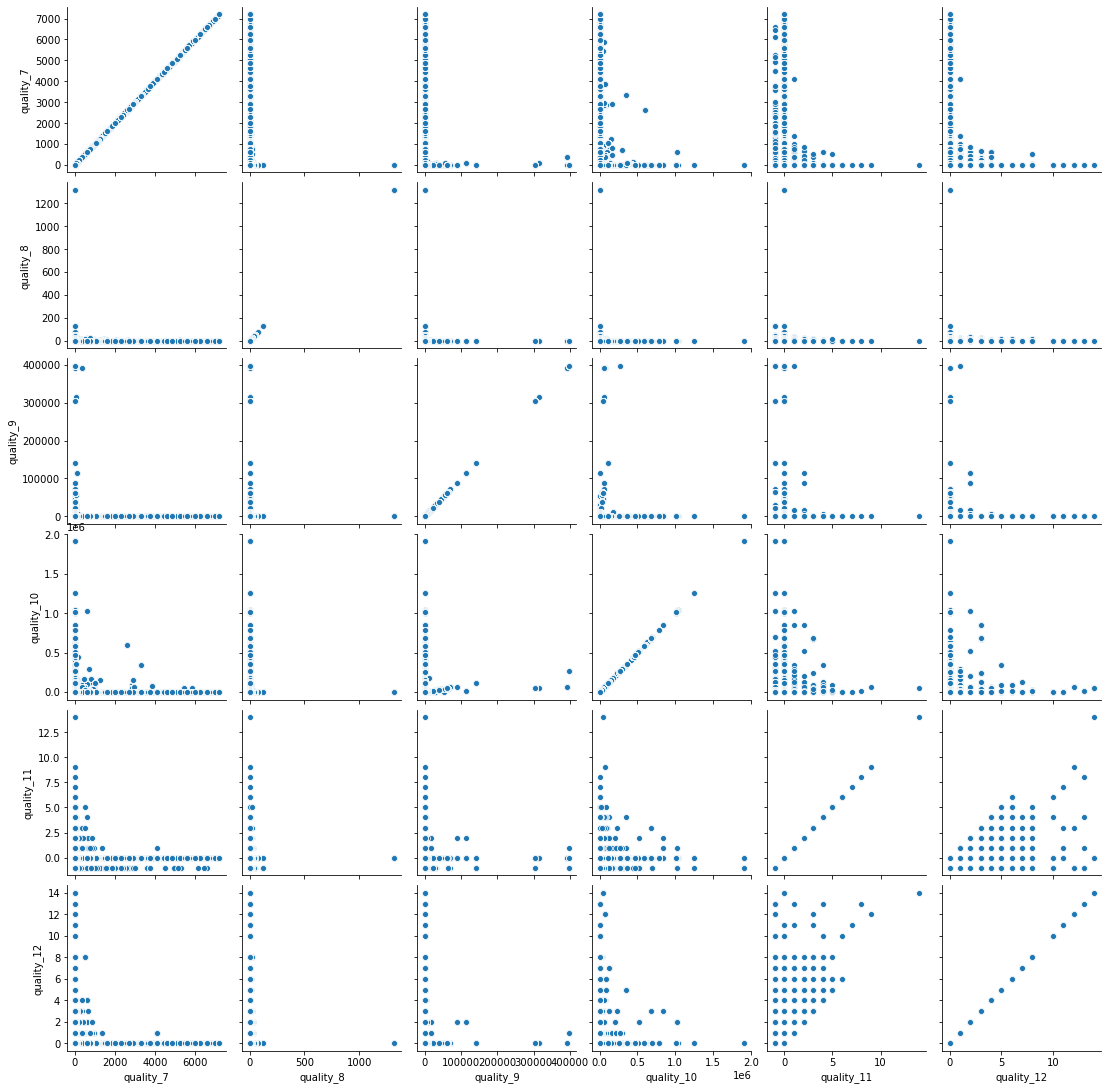

In [629]:
g = sns.PairGrid(tt[plot_qaulity[5:]])
g.map(sns.scatterplot)

전부 다 비교할 수는 없어서 얼추 반으로 쪼개서 플롯을 그려봤지만, 선형관계를 가지는 변수들은 거의 없습니다. 특히나 독립적인 변수들도 있습니다.

In [649]:
train_q.drop(['time'], axis=1, inplace=True)
test_q.drop(['time'], axis=1, inplace=True)

In [631]:
# 일단 쓸모 없는 3번과 4번은 버려주겠습니다.
train_q.drop(['quality_3', 'quality_4'], axis=1, inplace=True)
test_q.drop(['quality_3', 'quality_4'], axis=1, inplace=True)

In [650]:
# q변수들을 -1, 0, 1로 바꾸는 버전을 만들어보겠습니다.
def make_quality_encoding(df, columns):
    # 함수 정의: 변수를 받아서 -1, 0, 1로 값을 전부 바꾸는 함수
    
    for col in columns:
        new_list = []
        for i in df[col]:
            if i == 0:
                new_list.append(0)
            elif i == -1:
                new_list.append(-1)
            else:
                new_list.append(1)
                
        df[col] = new_list
        
    return df

In [651]:
train_q_1 = make_quality_encoding(train_q, plot_qaulity)
test_q_1 = make_quality_encoding(test_q, plot_qaulity)

In [681]:
train_q_1_pre = train_q_1.groupby(['user_id']).sum().dropna()
test_q_1_pre = test_q_1.groupby(['user_id']).sum().dropna()

In [653]:
# q변수들을 0, 1로 바꾸는 버전을 만들어보겠습니다.
def make_quality_encoding2(df, columns):
    # 함수 정의: 변수를 받아서 -1, 0, 1로 값을 전부 바꾸는 함수
    
    for col in columns:
        new_list = []
        for i in df[col]:
            if i == 0:
                new_list.append(0)
            else:
                new_list.append(1)
                
        df[col] = new_list
        
    return df

In [682]:
train_q_2 = make_quality_encoding2(train_q, plot_qaulity)
test_q_2 = make_quality_encoding2(test_q, plot_qaulity)

train_q_2_pre = train_q_2.groupby(['user_id']).sum().dropna()
test_q_2_pre = test_q_2.groupby(['user_id']).sum().dropna()

In [664]:
# q변수들을 -1을 0, 그 이상을 1로 바꾸는 버전을 만들어보겠습니다.
def make_quality_encoding3(df, columns):
    # 함수 정의: 변수를 받아서 -1, 0, 1로 값을 전부 바꾸는 함수
    
    for col in columns:
        new_list = []
        for i in df[col]:
            if i == 0:
                new_list.append(0)
            elif i == -1:
                new_list.append(0)
            else:
                new_list.append(1)
                
        df[col] = new_list
        
    return df

In [683]:
train_q_3 = make_quality_encoding3(train_q, plot_qaulity)
test_q_3 = make_quality_encoding3(test_q, plot_qaulity)

train_q_3_pre = train_q_3.groupby(['user_id']).sum().dropna()
test_q_3_pre = test_q_3.groupby(['user_id']).sum().dropna()

In [684]:
train_q_1_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
quality_0,8281.0,17.075474,71.691905,0.0,0.0,5.0,12.0,2697.0
quality_1,8281.0,19.122570,61.007834,0.0,0.0,6.0,13.0,1283.0
quality_2,8281.0,18.843376,73.266641,0.0,0.0,5.0,13.0,2697.0
quality_5,8281.0,48.364690,195.705300,0.0,4.0,9.0,22.0,3743.0
quality_6,8281.0,20.095037,63.990383,0.0,1.0,6.0,14.0,1386.0
quality_7,8281.0,8.554039,46.615005,0.0,0.0,0.0,12.0,1788.0
quality_8,8281.0,4.928390,25.023888,0.0,0.0,0.0,0.0,828.0
quality_9,8281.0,3.905325,71.027726,0.0,0.0,0.0,0.0,4092.0
quality_10,8281.0,92.935153,257.233267,0.0,12.0,24.0,60.0,4224.0
quality_11,8281.0,18.886004,60.859070,0.0,0.0,5.0,13.0,1279.0


In [685]:
train_q_2_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
quality_0,8281.0,17.075474,71.691905,0.0,0.0,5.0,12.0,2697.0
quality_1,8281.0,19.122570,61.007834,0.0,0.0,6.0,13.0,1283.0
quality_2,8281.0,18.843376,73.266641,0.0,0.0,5.0,13.0,2697.0
quality_5,8281.0,48.364690,195.705300,0.0,4.0,9.0,22.0,3743.0
quality_6,8281.0,20.095037,63.990383,0.0,1.0,6.0,14.0,1386.0
quality_7,8281.0,8.554039,46.615005,0.0,0.0,0.0,12.0,1788.0
quality_8,8281.0,4.928390,25.023888,0.0,0.0,0.0,0.0,828.0
quality_9,8281.0,3.905325,71.027726,0.0,0.0,0.0,0.0,4092.0
quality_10,8281.0,92.935153,257.233267,0.0,12.0,24.0,60.0,4224.0
quality_11,8281.0,18.886004,60.859070,0.0,0.0,5.0,13.0,1279.0


In [686]:
train_q_3_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
quality_0,8281.0,17.075474,71.691905,0.0,0.0,5.0,12.0,2697.0
quality_1,8281.0,19.122570,61.007834,0.0,0.0,6.0,13.0,1283.0
quality_2,8281.0,18.843376,73.266641,0.0,0.0,5.0,13.0,2697.0
quality_5,8281.0,48.364690,195.705300,0.0,4.0,9.0,22.0,3743.0
quality_6,8281.0,20.095037,63.990383,0.0,1.0,6.0,14.0,1386.0
quality_7,8281.0,8.554039,46.615005,0.0,0.0,0.0,12.0,1788.0
quality_8,8281.0,4.928390,25.023888,0.0,0.0,0.0,0.0,828.0
quality_9,8281.0,3.905325,71.027726,0.0,0.0,0.0,0.0,4092.0
quality_10,8281.0,92.935153,257.233267,0.0,12.0,24.0,60.0,4224.0
quality_11,8281.0,18.886004,60.859070,0.0,0.0,5.0,13.0,1279.0


In [689]:
train_user_q1 = pd.concat([train_user, train_q_1_pre], axis=1).fillna(0)
train_user_q2 = pd.concat([train_user, train_q_2_pre], axis=1).fillna(0)
train_user_q3 = pd.concat([train_user, train_q_3_pre], axis=1).fillna(0)

test_user_q1 = pd.concat([test_user, test_q_1_pre], axis=1).fillna(0)
test_user_q2 = pd.concat([test_user, test_q_2_pre], axis=1).fillna(0)
test_user_q3 = pd.concat([test_user, test_q_3_pre], axis=1).fillna(0)

In [778]:
def s_fold_train_pred(train_x, train_y):
    import lightgbm as lgb

    # Train
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': 42
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    s_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    

    for train_idx, val_idx in s_fold.split(train_x, train_y):

        # split train, validation set
        X = train_x.iloc[train_idx]
        y = train_y.iloc[train_idx]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y.iloc[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 20, 
                            early_stopping_rounds = 3
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    return models, auc_scores, recalls, precisions

In [ ]:
new_target = []
for i in train_new_p.target:
    if i == 0:
        new_target.append(0)
    else:
        new_target.append(1)
        
train_new_p.target = new_target


In [779]:
models, auc_scores, _, _ = s_fold_train_pred(train_user_q1, train_new_p)
print(np.mean(auc_scores))

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8953
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.797824	valid_0's pr_auc: 0.710732
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 12000, number of used feature

In [780]:
models, auc_scores, _, _ = s_fold_train_pred(train_user_q2, train_new_p)
print(np.mean(auc_scores))

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8953
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.797824	valid_0's pr_auc: 0.710732
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 12000, number of used feature

In [781]:
models, auc_scores, _, _ = s_fold_train_pred(train_user_q3, train_new_p)
print(np.mean(auc_scores))

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8953
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.797824	valid_0's pr_auc: 0.710732
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 12000, number of used feature

In [782]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_user_q3)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [787]:
submission.problem = pred_ensemble
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210110_3_test_quality-sfold.csv', index=False)

# MODELING

In [690]:
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------

## Comparing Vanila Model

## Hyper Parameter Tuning

## K-fold Cross Validation

## Ensemble & Stacking